# YOLO + Classifier
In this notebook I'm going to unify everything, I'm going to initialize the YOLO model and the classifier, then I'm going to test it by passing an image through the YOLO model, taking the coordinates of the detected traffic signs and then passing those cropped images of traffic signs through the classifier.

In [1]:
import os
import cv2
import csv
import glob
import random
import numpy as np
from tqdm import tqdm_notebook
from keras import backend as K
from keras.models import load_model
from yad2k.models.keras_yolo import yolo_eval, yolo_head

from models.cnn_models import *

%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


## YOLO initialization

In [2]:
# Define variables 
MODEL_PATH = 'yolo/yolo.h5'
ANCHORS_PATH = 'yolo/yolo_anchors.txt'
CLASSES_PATH = 'yolo/yolo_classes.txt'

In [3]:
# Get tensorflow session
sess = K.get_session() 

In [4]:
# Read classes names
with open(CLASSES_PATH) as f:
    class_names = f.readlines()
    class_names = [c.strip() for c in class_names]

In [5]:
# Read anchors
with open(ANCHORS_PATH) as f:
    anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    anchors = np.array(anchors).reshape(-1, 2)

In [6]:
# Load keras model
yolo_model = load_model(MODEL_PATH)

/home/arian/.virtualenvs/deeplearning/lib/python3.5/site-packages/keras/engine/topology.py:1210: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)
/home/arian/.virtualenvs/deeplearning/lib/python3.5/site-packages/keras/models.py:248: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [7]:
# Check if model is fully convolutional, assuming channel last order.
model_image_size = yolo_model.layers[0].input_shape[1:3]

In [8]:
# Generate output tensor targets for filtered bounding boxes.
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))
input_image_shape = K.placeholder(shape=(2, ))
boxes, scores, classes_yolo = yolo_eval(
    yolo_outputs,
    input_image_shape,
    score_threshold=0.3,
    iou_threshold=0.5)

In [9]:
# Function for testing a single image from the path 
def test_image(image):
    resized_image = cv2.resize(image, model_image_size)
    image_data = np.array(resized_image, dtype='float32')

    image_data /= 255.
    image_data = np.expand_dims(image_data, axis=0) 
    
    out_boxes, out_scores, out_classes = sess.run(
        [boxes, scores, classes_yolo],
        feed_dict={
            yolo_model.input: image_data,
            input_image_shape: [image.shape[0], image.shape[1]],
            K.learning_phase(): 0
        })
    
    # print('Found {} boxes for {}'.format(len(out_boxes), image_file))

    data = []
    
    for i, c in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[c]
        box = out_boxes[i]
        score = out_scores[i]

        label = '{} {:.2f}'.format(predicted_class, score)

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.shape[0], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.shape[1], np.floor(right + 0.5).astype('int32'))
        
        # print(label, (left, top), (right, bottom))
        
        item = [predicted_class, score, left, top, right, bottom]
        data.append(item)
    
    return data

## Classifier initialization

In [10]:
# Data path
data_path = 'data/custom/'

# Classes file
classes_file = 'classes.csv'

In [11]:
# Load classes
with open(os.path.join(data_path, classes_file), mode='r') as csv_file:
    reader = csv.reader(csv_file)
    classes = {rows[0]:rows[1] for rows in reader}

In [12]:
# Checkpoint path
checkpoint_path = 'checkpoints/'

# Model name
model_name = 'model_3_custom'

# Model function
model_function = model_3

# Weights path
weights_name = 'model_3_custom-weights-18-1.00.hdf5'
weights_path = os.path.join(os.path.join(checkpoint_path, model_name), weights_name)

In [13]:
model = model_function(weights_path)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 66, 66, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 66, 66, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 34, 34, 64)        0         
__________

# Test detection pipeline

1. Load image (or take image from video, webcam, etc).
2. Pass image through YOLO.
3. Parse detections and crop detected traffic signs.
4. Pass those crops through the classifier.
5. **;)**

In [14]:
# Define test image path
image_path = 'images/test-000190.jpg'

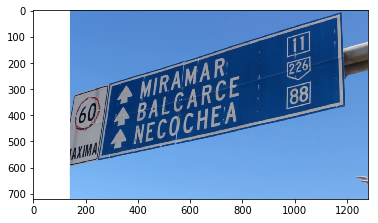

In [15]:
# 1. Read image
image = cv2.imread(image_path)
image = image[...,::-1]
plt.imshow(image)
plt.show()

In [17]:
# 2. YOLO pass
results = test_image(image)
print(results)

[['traffic-sign', 0.82875854, 151, 330, 265, 455]]


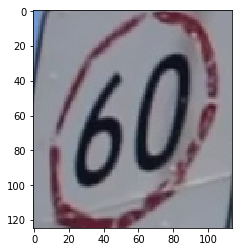

In [25]:
# 3. Crop traffic sign
x1, y1, x2, y2 = results[0][2:]
crop = image[y1:y2, x1:x2]
plt.imshow(crop)
plt.show()

In [26]:
# 4. Classifier pass
crop = cv2.resize(crop, (IMG_SIZE, IMG_SIZE))
crop = np.expand_dims(crop, axis=0)
predicted_class = model.predict_classes(crop, verbose=False)

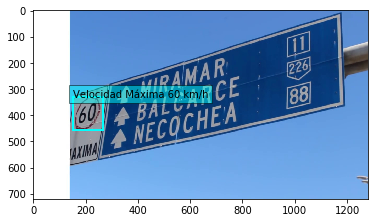

In [56]:
# 5. Show results
class_label = classes[str(predicted_class[0])]

plt.imshow(image)

ax = plt.gca()
ax.add_patch(plt.Rectangle((x1, y1), 
                           x2-x1, 
                           y2-y1, 
                           fill=False, 
                           edgecolor='cyan', 
                           linewidth=2))

ax.text(x1, y1, class_label, bbox={'facecolor':'cyan', 'alpha':0.5})
plt.show()